In [1]:
import Parity_Data_Generator
import numpy as np
from pyESN import ESN
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import time

rng = np.random.RandomState(42)

In [2]:
N = 20000   # number of datapoints (20000 is fine)
n = 3       # n-parity

start_time = time.time()
# produce Data
bits, parity, target = Parity_Data_Generator.generateParityData(N, n, randomstate=rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

print("--- %s seconds ---" % (time.time() - start_time))

--- 9.172013521194458 seconds ---


In [3]:
nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=500,  # from 200 onwards test error decreases significantly
                          spectral_radius=0.95,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= 0.1,   # adjust leak_rate
                          sparsity=0.95,
                          noise=0.001,
                          input_shift=0,
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          out_activation=np.tanh,
                          inverse_out_activation=np.arctanh,
                          random_state=rng,
                          silent=False)
nParityESN.fit(train_bits, train_parity)
pred_test = nParityESN.predict(test_bits)

    #### not rounding
predictedParity = pred_test # not rounding
    #### Rounding
#     better_pred_test = []           # Maybe don't round and return "true" results from pred_test
#     for x in pred_test:
#         better_pred_test.append(0 if x < 0.5 else 1)
#     predictedParity = np.array(better_pred_test).reshape(-1,1)
    
print("Testing error")
test_error = np.sqrt(np.mean((predictedParity - test_parity) ** 2))
print(test_error)

harvesting states...
fitting...
training error:
0.135680277863
Testing error
0.246477700568


# TODO: 
Produce new **_trainingParity+trainTargets_** from SlowESN to train FastESN to this kind of input and not **DemoData**

In [4]:
##### Create Training Data for fastESN with output from slowESN
new_rng = np.random.RandomState(1337)
new_N, new_n = 20000, 3
bits, parity, target = Parity_Data_Generator.generateParityData(new_N, new_n, randomstate=new_rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
# train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

train_predicted_parity = nParityESN.predict(train_bits)
test_predicted_parity = nParityESN.predict(test_bits)

In [5]:
outputESN = ESN(n_inputs=1,
                              n_outputs=1,
                              n_reservoir=100,  
                              spectral_radius=0.95,  # 0.95
                              leak_rate= 0.6,   # 0.6
                              sparsity=0.95,
                              noise=0.001,
                              input_shift=0,
                              input_scaling=3,  # 3 seems to be fine. Maybe use lower
                              teacher_scaling=1.12,
                              teacher_shift=-0.4,
                              out_activation=np.tanh,
                              inverse_out_activation=np.arctanh,
                              random_state=new_rng,
                              silent=False)
outputESN.fit(train_predicted_parity, train_targets)
# pred_targets = outputESN.predict(test_parity)  # demo data
pred_targets = outputESN.predict(test_predicted_parity) # what was actually predicted from slowESN

print("Testing error")
test_error = np.sqrt(np.mean((pred_targets - test_targets) ** 2))
print(test_error)

harvesting states...
fitting...
training error:
0.0778641348327
Testing error
0.172758375975


[[ 0.  ]
 [ 0.25]
 [ 0.  ]
 ..., 
 [ 0.5 ]
 [ 0.  ]
 [ 0.  ]]


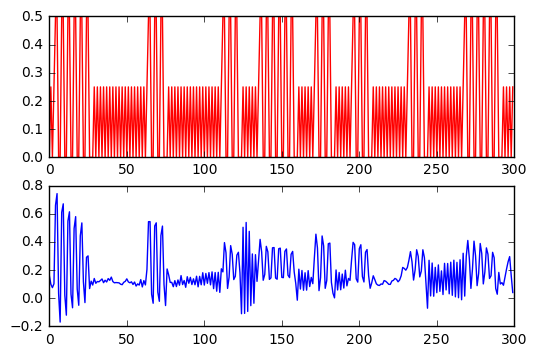

In [6]:
# Show Plots
print(test_targets)
plt.subplot(211)
plt.plot(test_targets[66500:66800], "r")
plt.subplot(212)
plt.plot(pred_targets[66500:66800], "b")
plt.show()